In [1]:
import pickle
import re
import numpy as np
import pandas as pd

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from mpstemmer import MPStemmer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
stopwords_ind = stopwords.words('indonesian')

factory = StemmerFactory()
stemmer = factory.create_stemmer()
lemmi = MPStemmer()

#### **Read File**

In [3]:
df = pd.read_csv('../datasets/handle_imbalance/indonlu_handle_imbalance_v8.csv')

In [4]:
key_norm = pd.read_csv('../corpus/colloquial-indonesian-lexicon.csv')

#### **Preprocessing**

In [5]:
def casefolding(string):
    string = string.lower()
    string = re.sub(r'https?://\S+|www\.\S+', '', string) # remove URLs
    string = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", '', string) # remove punctuations and special characters
    # string = re.sub(r'[^\w\s]','', string) # remove tanda baca
    string = re.sub(r"[^A-Za-z0-9(),!?\'\-`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    # Menghapus enter
    string = re.sub(r"\n", "", string)

    # Membersihkan elemen yang tidak perlu, seperti menghapus spasi 2
    string = re.sub(r"\'re", " \'re", string)

    # Mengecek digit atau bukan
    string = re.sub(r"\'d", " \'d", string)

    # Mengecek long atau bukan
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.strip()
    # Menghilangkan imbuhan
    
    return string

In [6]:
def textNormalize(string):
    # Split the input string into words
    words = string.split()
    # Replace slang words with their formal equivalents
    string = ' '.join([key_norm[key_norm['slang'] == word]['formal'].values[0] if (key_norm['slang'] == word).any() else word for word in words])
    string = string.lower()
    return string

In [7]:
more_stop_words = []

stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

In [8]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

In [9]:
def stemming(Ulasan):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in Ulasan:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
#   print(d_clean)
  return d_clean

In [10]:
def lemmitization(text):
    text = lemmi.stem(text)
    return text

In [11]:
df['cleaned_text'] = df['text'].apply(lambda x: casefolding(x))

In [12]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: textNormalize(x))

In [13]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: stopword(x))

In [14]:
df.to_csv('../datasets/cleaned/indonlu_smsa_cleaned.csv', index=False)

In [15]:
df['preprocessed_text'] = df['cleaned_text'].apply(tokenization)

In [16]:
df['preprocessed_text'] = df['cleaned_text'].apply(stemming)

In [17]:
df['preprocessed_text'] = df['cleaned_text'].apply(lemmitization)

In [18]:
df.to_csv('../datasets/preprocessed/indonlu_smsa_preprocessed.csv', index=False)

#### **Prepare Extraction Feature**

In [3]:
df = pd.read_csv('../datasets/preprocessed/indonlu_smsa_preprocessed.csv')

In [4]:
df.head()

,text,label,cleaned_text,preprocessed_text
0,demi apa pun gua ingin marah indosat cacat ban...,negative,apa gua marah indosat cacat banget sih,apa gua marah indosat cacat banget sih
1,yang benar saja masa nomer whatsapp saya di bl...,negative,benar masa nomer whatsapp di blok mana penangg...,benar masa nomer whatsapp di blok mana penangg...
2,aduh toyota prado segala rusak,negative,aduh toyota prado segala rusak,aduh toyota prado segala rusak
3,demi yang hanya untuk pencitraan mencari simpa...,negative,yang untuk pencitraan mencari simpati rakyat t...,yang untuk pencitraan mencari simpati rakyat t...
4,yang tidak kereta mutiara timur malam sby bnyw...,negative,tidak kereta mutiara timur malam surabaya bnyw...,tidak kereta mutiara timur malam surabaya bnyw...


In [5]:
# Memastikan kolom 'label' berbentuk DataFrame 2-dimensi
sentiments = df[['label']]

# Menginisialisasi dan menerapkan OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_sentiments = encoder.fit_transform(sentiments)

# Menampilkan hasil
print(encoded_sentiments)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [6]:
# Create a DataFrame to display the results
encoded_df = pd.DataFrame(encoded_sentiments, columns=encoder.categories_[0])

# Concatenate the encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df, encoded_df], axis=1)

# Display the DataFrame with encoded sentiments
print(df_encoded.iloc[1])

text                 yang benar saja masa nomer whatsapp saya di bl...
label                                                         negative
cleaned_text         benar masa nomer whatsapp di blok mana penangg...
preprocessed_text    benar masa nomer whatsapp di blok mana penangg...
negative                                                           1.0
neutral                                                            0.0
positive                                                           0.0
Name: 1, dtype: object


In [5]:
encoded_label = df['label'].map({'negative' : 0, 'neutral' : 1, 'positive' : 2}).values

#### **Extraction Feature**

In [6]:
# Tokenisasi teks
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['preprocessed_text'])

# Padding sequences agar memiliki panjang yang sama
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Menampilkan hasil
print(padded_sequences)

# padded_sequences => sebagai featurenya berbentuk vector

[[   0    0    0 ... 4970   31   76]
 [   0    0    0 ...  606 1486  250]
 [   0    0    0 ... 1374  747  924]
 ...
 [   0    0    0 ...  634  696 2505]
 [   0    0    0 ... 3786 1540 4217]
 [   0    0    0 ... 2458 2925 4199]]


#### **Modeling**

In [7]:
# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_label, test_size=0.2, random_state=42)

# output dari feature di masukkan ke set pelatihan dan pengujian, yang nantinya digunakan untuk mmebuat model

In [10]:
# Define early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.0001, restore_best_weights=True)

In [200]:
# Parameter model
vocab_size = len(tokenizer.word_index) + 1  # Ditambah 1 untuk padding token
embedding_dim = 100
max_length = 100  # Menetapkan max_length sesuai dengan padding sequence

def create_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        Bidirectional(LSTM(units=64, dropout=0.2)),
        Dense(units=3, activation='softmax')
    ])

    # Kompilasi model
    model.compile(
        loss='sparse_categorical_crossentropy', # ketika menggunakan ordinal encoder, kalau menggunakan one-hot encoder maka menggunakan _categorical_crossentropy
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    # Membangun model
    model.build(input_shape=(None, max_length)) # untuk menggunakan embedding

    # Menampilkan ringkasan model setelah memberikan contoh data untuk menentukan bentuk layer
    model.summary()

    return model

# Create the model
model = create_model()

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_49 (Embedding)        │ (None, 100, 100)       │     1,534,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_55                │ (None, 128)            │        84,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,618,967 (6.18 MB)

 Trainable params: 1,618,967 (6.18 MB)

 Non-trainable params: 0 (0.00 B)

In [201]:
# Train and evaluate the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stop])

Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.5641 - loss: 0.9188 - val_accuracy: 0.8510 - val_loss: 0.4328
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.8791 - loss: 0.3301 - val_accuracy: 0.8864 - val_loss: 0.3055
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.9407 - loss: 0.1688 - val_accuracy: 0.8927 - val_loss: 0.3107
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9687 - loss: 0.0982 - val_accuracy: 0.8902 - val_loss: 0.3443
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.9786 - loss: 0.0692 - val_accuracy: 0.8889 - val_loss: 0.3897
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.9853 - loss: 0.0475 - val_accuracy: 0.8851 - val_loss: 0.4227


In [202]:
# Mengevaluasi performa model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8886 - loss: 0.3181
Validation Loss: 0.33053743839263916
Test Accuracy: 0.8853535056114197


#### **Evaluasi Model**

In [22]:
# Evaluasi model pada set pelatihan
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Prediksi label untuk set pelatihan
y_train_pred = model.predict(X_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Menghasilkan laporan klasifikasi untuk set pelatihan
train_report = classification_report(y_train, y_train_pred_classes, target_names=['negative', 'neutral', 'positive'])
print("Training Classification Report:\n", train_report)

248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9737 - loss: 0.0944
Training Accuracy: 96.52%
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Training Classification Report:
               precision    recall  f1-score   support

    negative       0.94      0.97      0.95      2629
     neutral       0.99      0.98      0.99      2625
    positive       0.97      0.95      0.96      2666

    accuracy                           0.97      7920
   macro avg       0.97      0.97      0.97      7920
weighted avg       0.97      0.97      0.97      7920



In [21]:
# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Prediksi label untuk set pengujian
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Menghasilkan laporan klasifikasi
report = classification_report(y_test, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
print(report)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8886 - loss: 0.3181
Test Accuracy: 88.54%
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

    negative       0.84      0.86      0.85       671
     neutral       0.95      0.92      0.94       675
    positive       0.87      0.87      0.87       634

    accuracy                           0.89      1980
   macro avg       0.89      0.89      0.89      1980
weighted avg       0.89      0.89      0.89      1980



In [ ]:
# # Train and evaluate the model
# Bidirectional(LSTM(units=64, dropout=0.2)),, sparse_categorical_crossentropy
# history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stop])

# 62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8886 - loss: 0.3181
# Validation Loss: 0.33053743839263916
# Test Accuracy: 0.8853535056114197

#### **Save Model**

In [203]:
# Save the model as an keras file
model.save('../model/bilstm/model_bilstm.keras')

In [204]:
# Simpan history ke file pickle
with open('../model/bilstm/history_bilstm.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [205]:
# Save the model weights
model.save_weights('../model/bilstm/model_weights_bilstm.weights.h5')

In [206]:
# Save the model as a PKL file
# Save the model architecture as a JSON string
model_json = model.to_json()
with open('../model/bilstm/model_architecture_bilstm.json', 'w') as json_file:
    json_file.write(model_json)

In [207]:
# Save the model as a pickle file
with open('../model/bilstm/model_bilstm.pkl', 'wb') as pkl_file:
    pickle.dump({'../model/bilstm/model_architecture_bilstm': model_json, '../model/bilstm/model_weights_bilstm': model.get_weights()}, pkl_file)

In [209]:
# Save tokenizer's word index
with open('../model/bilstm/tokenizer_word_index_bilstm.pkl', 'wb') as f:
    pickle.dump(tokenizer.word_index, f)

# Save tokenizer's configuration
tokenizer_config = {
    'num_words': tokenizer.num_words,
    'filters': tokenizer.filters,
    'lower': tokenizer.lower,
    'split': tokenizer.split,
    'char_level': tokenizer.char_level,
    'oov_token': tokenizer.oov_token,
    'document_count': tokenizer.document_count
}

with open('../model/bilstm/tokenizer_config_bilstm.pkl', 'wb') as f:
    pickle.dump(tokenizer_config, f)

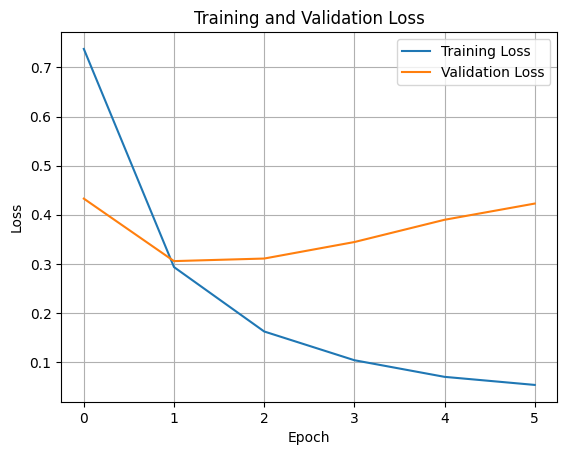

In [210]:
# Memuat history dari file pickle
with open('../model/bilstm/history_bilstm.pkl', 'rb') as file:
    history = pickle.load(file)

# Membuat grafik loss
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

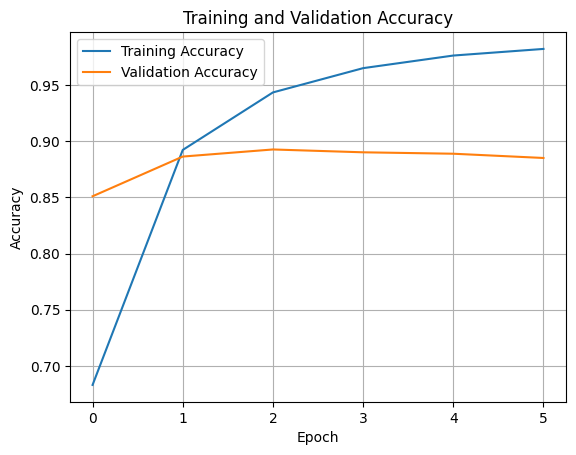

In [230]:
# Memuat history dari file pickle
with open('../model/bilstm/history_bilstm.pkl', 'rb') as file:
    history = pickle.load(file)

# Membuat grafik loss
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### **Load Model**

In [212]:
from tensorflow.keras.models import Sequential, load_model

In [12]:
from tensorflow.keras.models import Sequential, load_model

In [13]:
model = load_model('../model/bilstm/model_bilstm.keras')

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8886 - loss: 0.3181


In [229]:
import re

def preprocess_text(text):
    # Replace 'sampah' with 'sampah-nya'
    text = re.sub(r'\bsampah\b', 'sampahnya', text)
    return text

# Example usage
feedback = input("Your Feedback:")
feedback_processed = preprocess_text(feedback)

# Example new data to predict
new_texts = [feedback_processed]

# Tokenize new data
sequences = tokenizer.texts_to_sequences(new_texts)

# Padding sequences
max_length = 100  # Adjust according to your model's max_length
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Load the saved model
model = load_model('../model/bilstm/model_bilstm.keras')

# Perform prediction
predictions = model.predict(padded_sequences)

# Example of printing predictions
for text, prediction in zip(new_texts, predictions):
    print(f'Text: {feedback}')
    print(f'Prediction: {prediction}')

    # Find the index of the maximum value
    if np.argmax(prediction) == 0:
        print("Sentiment: negative")
    elif np.argmax(prediction) == 1:
        print("Sentiment: neutral")
    elif np.argmax(prediction) == 2:
        print("Sentiment: positive")

    # Find the maximum value in the prediction array
    max_value = max(prediction)
    print(f'Highest Score: {max_value}')

    print(f'Score Negative: {prediction[0]}')
    print(f'Score Neutral: {prediction[1]}')
    print(f'Score Positive: {prediction[2]}')
    print()  # For spacing between outputs


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Text: tempat sampah bocor dan tak layak pakai
Prediction: [0.6010638  0.04275477 0.35618147]
Sentiment: negative
Highest Score: 0.6010637879371643
Score Negative: 0.6010637879371643
Score Neutral: 0.042754773050546646
Score Positive: 0.35618147253990173

